In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-02-25 15:30:46.218826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 15:30:48.637195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nimahsn/anaconda3/envs/tf2/lib/
2023-02-25 15:30:48.637325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nimahsn/anaconda3/envs/tf2/lib/
2023-02-25 15:30:48.637336: W tensorflow/compiler/tf2t

In [2]:
from data.reaction_diffusion import reaction_diffusion_discrete_solution
from modules.models import ReactionDiffusionPinn, create_dense_model
from modules.data import simulate_reaction_diffusion
from modules.plots import plot_training_loss_linlog
from modules.utils import PrintLossCallback

In [3]:
nt = 150
nx = 256
n_samples = 400
n_init = 100
n_bcs = 200
u0 = 'gauss'
rho = 15.0
nu = 13.0
(tx_samples, u_samples, y_residuals), (tx_init, u_init), (tx_bnd, u_bnd), (X, T, U) = simulate_reaction_diffusion(
    n_samples, n_init, n_bcs, reaction_diffusion_discrete_solution, u0, nu, rho)

2023-02-25 15:30:55.681337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 15:30:55.836482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 15:30:55.837510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 15:30:55.841590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [4]:
# create tensorflow datasets of txs and us
tx_samples = tf.data.Dataset.from_tensor_slices(tx_samples)
u_samples = tf.data.Dataset.from_tensor_slices(u_samples)
y_residuals = tf.data.Dataset.from_tensor_slices(y_residuals)
tx_init = tf.data.Dataset.from_tensor_slices(tx_init).repeat(4)
u_init = tf.data.Dataset.from_tensor_slices(u_init).repeat(4)
tx_bnd = tf.data.Dataset.from_tensor_slices(tx_bnd).repeat(2)
u_bnd = tf.data.Dataset.from_tensor_slices(u_bnd).repeat(2)

inputs = tf.data.Dataset.zip((tx_samples, tx_init, tx_bnd))
outputs = tf.data.Dataset.zip((u_samples, y_residuals, u_init, u_bnd))
dataset = tf.data.Dataset.zip((inputs, outputs)).batch(128)

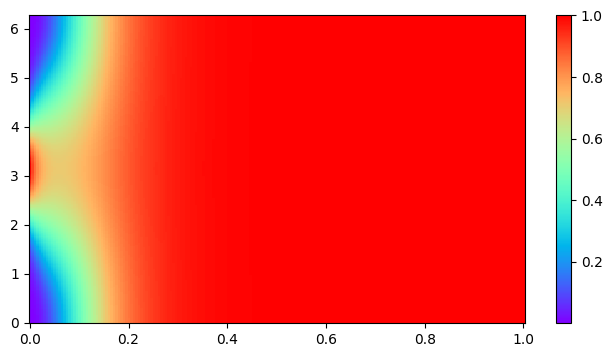

In [5]:
# plot color map of solution
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, U, cmap='rainbow')
plt.colorbar()

In [6]:
backbone = create_dense_model([750, 750], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
reaction_f = ReactionDiffusionPinn.get_fishers_reaction_function(rho)
model = ReactionDiffusionPinn(backbone, nu, reaction_f) 
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer)

In [7]:
cb = [PrintLossCallback(5000-1)]
history = model.fit(dataset, epochs=50000, batch_size=128, verbose=0, callbacks=cb)


2023-02-25 15:31:06.863773: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f528400dcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-25 15:31:06.863829: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2023-02-25 15:31:06.873047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-25 15:31:07.021447: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-25 15:31:07.074801: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 000000, Lr: 9450.61719, Li: 3.64145, Lb: 4.11688, MAE: 1.30036
Epoch: 004999, Lr: 0.02022, Li: 0.05321, Lb: 0.00479, MAE: 0.02808
Epoch: 009998, Lr: 0.00313, Li: 0.01133, Lb: 0.00038, MAE: 0.00882
Epoch: 014997, Lr: 0.00182, Li: 0.00442, Lb: 0.00039, MAE: 0.00870
Epoch: 019996, Lr: 0.00111, Li: 0.00236, Lb: 0.00032, MAE: 0.00825
Epoch: 024995, Lr: 0.00099, Li: 0.00166, Lb: 0.00032, MAE: 0.00867
Epoch: 029994, Lr: 0.00092, Li: 0.00147, Lb: 0.00033, MAE: 0.00888
Epoch: 034993, Lr: 0.00088, Li: 0.00140, Lb: 0.00033, MAE: 0.00896
Epoch: 039992, Lr: 0.00087, Li: 0.00137, Lb: 0.00033, MAE: 0.00899
Epoch: 044991, Lr: 0.00087, Li: 0.00136, Lb: 0.00033, MAE: 0.00900
Epoch: 049990, Lr: 0.00087, Li: 0.00136, Lb: 0.00033, MAE: 0.00901


1600/1600 [==============================] - 5s 3ms/step


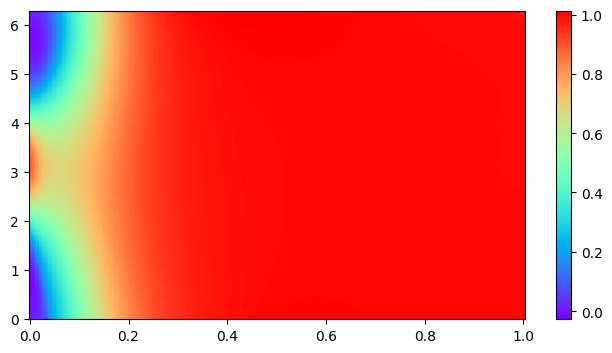

In [16]:
# plot prediction
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape), cmap='rainbow')
plt.colorbar()

In [10]:
# save backbone
backbone.save('backbone.h5')

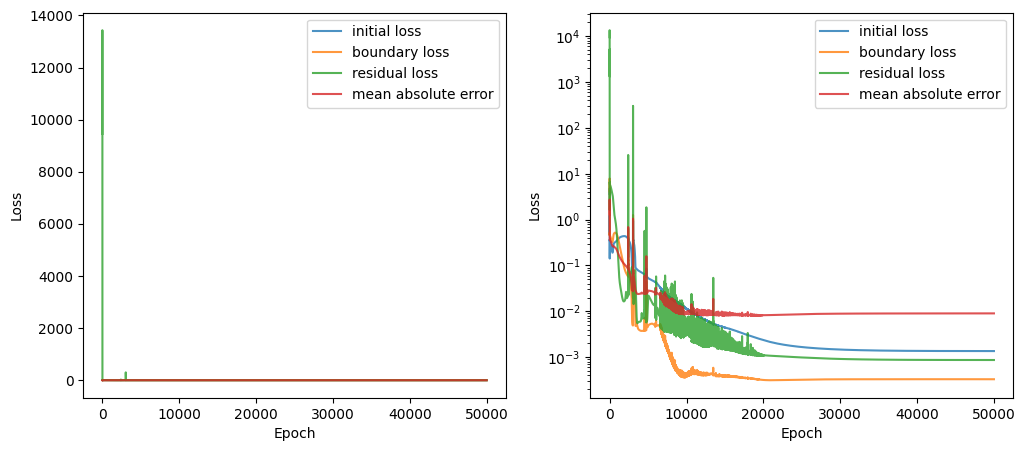

In [12]:
plot_training_loss_linlog(history.history)

In [13]:
from modules.plots import plot_pointwise_error_mesh

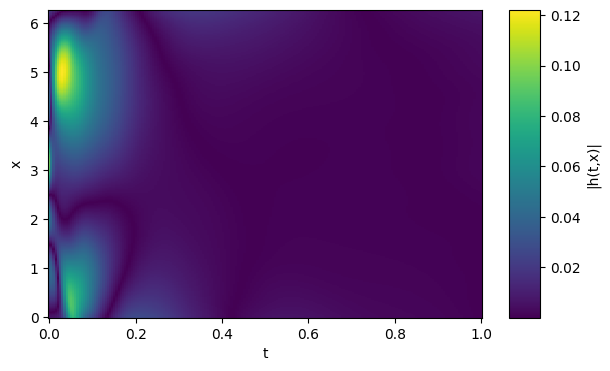

In [15]:
plot_pointwise_error_mesh(tf.reshape(U, (-1, 1)), tf.reshape(u_pred, [-1, 1]), T, X)